# Chapter 16: Bayesian statistics

Robert Johansson

Source code listings for [Numerical Python - A Practical Techniques Approach for Industry](http://www.apress.com/9781484205549) (ISBN 978-1-484205-54-9).

The source code listings can be downloaded from http://www.apress.com/9781484205549

In [2]:
import pymc3 as mc 

In [3]:
import numpy as np

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

In [5]:
import seaborn as sns

In [6]:
from scipy import stats

In [7]:
import statsmodels.api as sm

In [8]:
import statsmodels.formula.api as smf

In [9]:
import pandas as pd

## Changelog:

* 160828: The keyword argument `vars` to the function `mc.traceplot` was changed to `varnames`.

# Simple example: Normal distributed random variable

In [10]:
# try this
# dir(mc.distributions)

In [11]:
np.random.seed(100)

In [12]:
mu = 4.0

In [13]:
sigma = 2.0

In [14]:
model = mc.Model()

In [15]:
with model:
    mc.Normal('X', mu, 1/sigma**2)

In [16]:
model.vars

[X]

In [17]:
start = dict(X=2)

In [18]:
with model:
    step = mc.Metropolis()
    trace = mc.sample(10000, step=step, start=start)

 [-----------------100%-----------------] 10000 of 10000 complete in 1.0 sec

In [19]:
x = np.linspace(-4, 12, 1000)

In [20]:
y = stats.norm(mu, sigma).pdf(x)

In [21]:
X = trace.get_values("X")

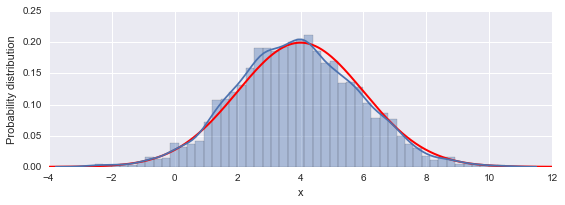

In [22]:
fig, ax = plt.subplots(figsize=(8, 3))

ax.plot(x, y, 'r', lw=2)
sns.distplot(X, ax=ax)
ax.set_xlim(-4, 12)
ax.set_xlabel("x")
ax.set_ylabel("Probability distribution")
fig.tight_layout()
fig.savefig("ch16-normal-distribution-sampled.pdf")

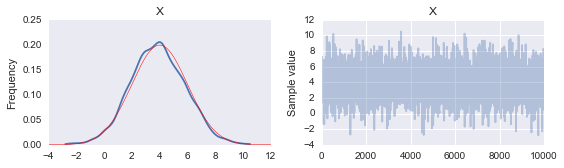

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(8, 2.5), squeeze=False)
mc.traceplot(trace, ax=axes)
axes[0,0].plot(x, y, 'r', lw=0.5)
fig.tight_layout()
fig.savefig("ch16-normal-sampling-trace.png")
fig.savefig("ch16-normal-sampling-trace.pdf")

## Dependent random variables

In [24]:
model = mc.Model()

In [25]:
with model:
    mean = mc.Normal('mean', 3.0)
    sigma = mc.HalfNormal('sigma', sd=1.0)
    X = mc.Normal('X', mean, sd=sigma)

Applied log-transform to sigma and added transformed sigma_log_ to model.


In [26]:
model.vars

[mean, sigma_log_, X]

In [27]:
with model:
    start = mc.find_MAP()

In [28]:
start

{'X': array(3.0), 'mean': array(3.0), 'sigma_log_': array(-5.990881458971846)}

In [29]:
with model:
    step = mc.Metropolis()
    trace = mc.sample(100000, start=start, step=step)

 [-----------------100%-----------------] 100000 of 100000 complete in 25.1 sec

In [30]:
trace.get_values('sigma').mean()

0.79416747229277795

In [31]:
X = trace.get_values('X')

In [32]:
X.mean()

2.9723368148353306

In [33]:
trace.get_values('X').std()

1.4192894166989034

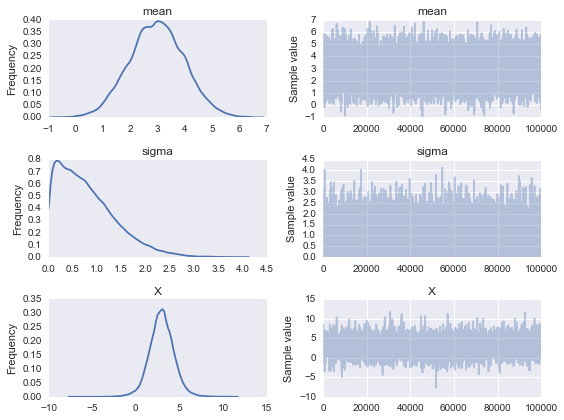

In [34]:
fig, axes = plt.subplots(3, 2, figsize=(8, 6), squeeze=False)
mc.traceplot(trace, varnames=['mean', 'sigma', 'X'], ax=axes)
fig.tight_layout()
fig.savefig("ch16-dependent-rv-sample-trace.png")
fig.savefig("ch16-dependent-rv-sample-trace.pdf")

## Posterior distributions

In [35]:
mu = 2.5

In [36]:
s = 1.5

In [37]:
data = stats.norm(mu, s).rvs(100)

In [38]:
with mc.Model() as model:
    
    mean = mc.Normal('mean', 4.0, 1.0) # true 2.5
    sigma = mc.HalfNormal('sigma', 3.0 * np.sqrt(np.pi/2)) # true 1.5

    X = mc.Normal('X', mean, 1/sigma**2, observed=data)

Applied log-transform to sigma and added transformed sigma_log_ to model.


In [39]:
model.vars

[mean, sigma_log_]

In [40]:
with model:
    start = mc.find_MAP()
    step = mc.Metropolis()
    trace = mc.sample(100000, start=start, step=step)
    #step = mc.NUTS()
    #trace = mc.sample(10000, start=start, step=step)

 [-----------------100%-----------------] 100000 of 100000 complete in 19.3 sec

In [41]:
start

{'mean': array(2.4946001673247844), 'sigma_log_': array(0.49482580625475275)}

In [42]:
model.vars

[mean, sigma_log_]

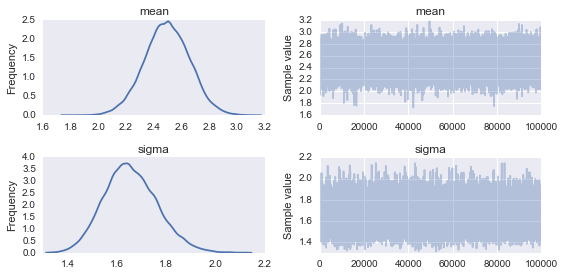

In [43]:
fig, axes = plt.subplots(2, 2, figsize=(8, 4), squeeze=False)
mc.traceplot(trace, varnames=['mean', 'sigma'], ax=axes)
fig.tight_layout()
fig.savefig("ch16-posterior-sample-trace.png")
fig.savefig("ch16-posterior-sample-trace.pdf")

In [44]:
mu, trace.get_values('mean').mean()

(2.5, 2.4949295037723633)

In [45]:
s, trace.get_values('sigma').mean()

(1.5, 1.656805248516918)

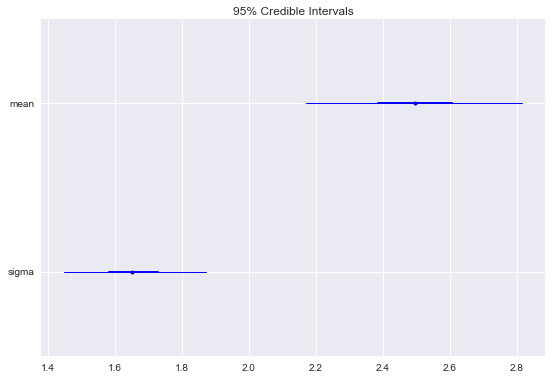

In [46]:
gs = mc.forestplot(trace, varnames=['mean', 'sigma'])
plt.savefig("ch16-forestplot.pdf")

In [47]:
help(mc.summary)

Help on function summary in module pymc3.stats:

summary(trace, varnames=None, alpha=0.05, start=0, batches=100, roundto=3, include_transformed=False, to_file=None)
    Generate a pretty-printed summary of the node.
    
    :Parameters:
    trace : Trace object
      Trace containing MCMC sample
    
    varnames : list of strings
      List of variables to summarize. Defaults to None, which results
      in all variables summarized.
    
    alpha : float
      The alpha level for generating posterior intervals. Defaults to
      0.05.
    
    start : int
      The starting index from which to summarize (each) chain. Defaults
      to zero.
    
    batches : int
      Batch size for calculating standard deviation for non-independent
      samples. Defaults to 100.
    
    roundto : int
      The number of digits to round posterior statistics.
            
    include_transformed : bool
      Flag for summarizing automatically transformed variables in addition to 
      original va

In [48]:
mc.summary(trace, varnames=['mean', 'sigma'])


mean:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  2.495            0.164            0.001            [2.170, 2.815]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  2.170          2.385          2.495          2.606          2.815


sigma:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  1.657            0.109            0.001            [1.449, 1.873]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  1.458          1.582          1.651          1.727          1.885



## Linear regression

In [49]:
dataset = sm.datasets.get_rdataset("Davis", "car")

In [50]:
data = dataset.data[dataset.data.sex == 'M']

In [51]:
data = data[data.weight < 110]

In [52]:
data.head(3)

,sex,weight,height,repwt,repht
0,M,77,182,77.0,180.0
3,M,68,177,70.0,175.0
5,M,76,170,76.0,165.0


In [53]:
model = smf.ols("height ~ weight", data=data)

In [54]:
result = model.fit()

In [55]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                 height   R-squared:                       0.327
Model:                            OLS   Adj. R-squared:                  0.319
Method:                 Least Squares   F-statistic:                     41.35
Date:                Sun, 28 Aug 2016   Prob (F-statistic):           7.11e-09
Time:                        17:26:35   Log-Likelihood:                -268.20
No. Observations:                  87   AIC:                             540.4
Df Residuals:                      85   BIC:                             545.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    152.6173      3.987     38.281      0.0

In [56]:
x = np.linspace(50, 110, 25)

In [57]:
y = result.predict({"weight": x})

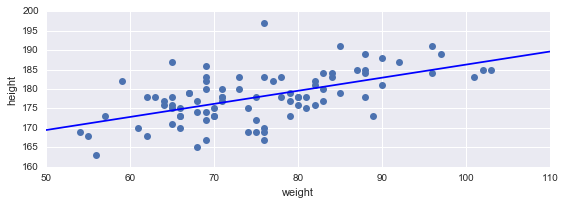

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
ax.plot(data.weight, data.height, 'o')
ax.plot(x, y, color="blue")
ax.set_xlabel("weight")
ax.set_ylabel("height")
fig.tight_layout()
fig.savefig("ch16-linear-ols-fit.pdf")

In [59]:
with mc.Model() as model:
    sigma = mc.Uniform('sigma', 0, 10)
    intercept = mc.Normal('intercept', 125, sd=30)
    beta = mc.Normal('beta', 0, sd=5)
    
    height_mu = intercept + beta * data.weight

    # likelihood function
    mc.Normal('height', mu=height_mu, sd=sigma, observed=data.height)

    # predict
    predict_height = mc.Normal('predict_height', mu=intercept + beta * x, sd=sigma, shape=len(x)) 

Applied interval-transform to sigma and added transformed sigma_interval_ to model.


In [60]:
model.vars

[sigma_interval_, intercept, beta, predict_height]

In [61]:
with model:
    start = mc.find_MAP()
    step = mc.NUTS(state=start)
    trace = mc.sample(10000, step, start=start)

 [-----------------100%-----------------] 10000 of 10000 complete in 17.1 sec

In [62]:
model.vars

[sigma_interval_, intercept, beta, predict_height]

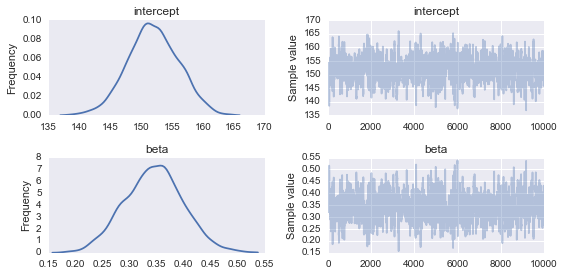

In [63]:
fig, axes = plt.subplots(2, 2, figsize=(8, 4), squeeze=False)
mc.traceplot(trace, varnames=['intercept', 'beta'], ax=axes)
fig.savefig("ch16-linear-model-sample-trace.pdf")
fig.savefig("ch16-linear-model-sample-trace.png")

In [64]:
intercept = trace.get_values("intercept").mean()
intercept

151.96417056576311

In [65]:
beta = trace.get_values("beta").mean()
beta

0.3450343361373257

In [66]:
result.params

Intercept    152.617348
weight         0.336477
dtype: float64

In [67]:
result.predict({"weight": 90})

array([ 182.90030002])

In [68]:
weight_index = np.where(x == 90)[0][0]

In [69]:
trace.get_values("predict_height")[:, weight_index].mean()

182.91619355453892

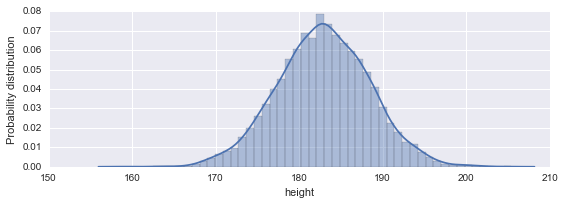

In [70]:
fig, ax = plt.subplots(figsize=(8, 3))

sns.distplot(trace.get_values("predict_height")[:, weight_index], ax=ax)
ax.set_xlim(150, 210)
ax.set_xlabel("height")
ax.set_ylabel("Probability distribution")
fig.tight_layout()
fig.savefig("ch16-linear-model-predict-cut.pdf")

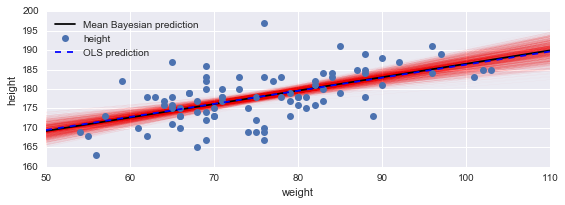

In [71]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))

for n in range(500, 2000, 1):
    intercept = trace.get_values("intercept")[n]
    beta = trace.get_values("beta")[n]
    ax.plot(x, intercept + beta * x, color='red', lw=0.25, alpha=0.05)

intercept = trace.get_values("intercept").mean()
beta = trace.get_values("beta").mean()
ax.plot(x, intercept + beta * x, color='k', label="Mean Bayesian prediction")

ax.plot(data.weight, data.height, 'o')
ax.plot(x, y, '--', color="blue", label="OLS prediction")
ax.set_xlabel("weight")
ax.set_ylabel("height")
ax.legend(loc=0)
fig.tight_layout()
fig.savefig("ch16-linear-model-fit.pdf")
fig.savefig("ch16-linear-model-fit.png")

In [72]:
with mc.Model() as model:
    mc.glm.glm('height ~ weight', data)
    step = mc.NUTS()
    trace = mc.sample(2000, step)

Applied log-transform to sd and added transformed sd_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 12.9 sec

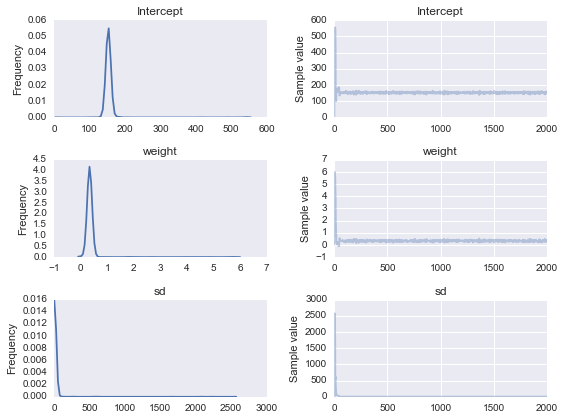

In [73]:
fig, axes = plt.subplots(3, 2, figsize=(8, 6), squeeze=False)
mc.traceplot(trace, varnames=['Intercept', 'weight', 'sd'], ax=axes)
fig.tight_layout()
fig.savefig("ch16-glm-sample-trace.pdf")
fig.savefig("ch16-glm-sample-trace.png")

## Multilevel model

In [74]:
dataset = sm.datasets.get_rdataset("Davis", "car")

In [75]:
data = dataset.data.copy()
data = data[data.weight < 110]

In [76]:
data["sex"] = data["sex"].apply(lambda x: 1 if x == "F" else 0)

In [77]:
data.head()

,sex,weight,height,repwt,repht
0,0,77,182,77.0,180.0
1,1,58,161,51.0,159.0
2,1,53,161,54.0,158.0
3,0,68,177,70.0,175.0
4,1,59,157,59.0,155.0


In [78]:
with mc.Model() as model:

    # heirarchical model: hyper priors
    #intercept_mu = mc.Normal("intercept_mu", 125)
    #intercept_sigma = 30.0 #mc.Uniform('intercept_sigma', lower=0, upper=50)
    #beta_mu = mc.Normal("beta_mu", 0.0)
    #beta_sigma = 5.0 #mc.Uniform('beta_sigma', lower=0, upper=10)
    
    # multilevel model: prior parameters
    intercept_mu, intercept_sigma = 125, 30
    beta_mu, beta_sigma = 0.0, 5.0
    
    # priors
    intercept = mc.Normal('intercept', intercept_mu, sd=intercept_sigma, shape=2)
    beta = mc.Normal('beta', beta_mu, sd=beta_sigma, shape=2)
    error = mc.Uniform('error', 0, 10)

    # model equation
    sex_idx = data.sex.values
    height_mu = intercept[sex_idx] + beta[sex_idx] * data.weight

    mc.Normal('height', mu=height_mu, sd=error, observed=data.height)

Applied interval-transform to error and added transformed error_interval_ to model.


In [79]:
model.vars

[intercept, beta, error_interval_]

In [80]:
with model:
    start = mc.find_MAP()
    step = mc.NUTS(state=start)
    hessian = mc.find_hessian(start)
    trace = mc.sample(5000, step, start=start)

 [-----------------100%-----------------] 5000 of 5000 complete in 28.2 sec

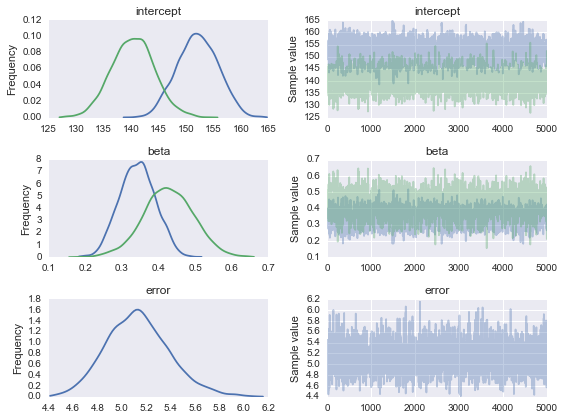

In [81]:
fig, axes = plt.subplots(3, 2, figsize=(8, 6), squeeze=False)
mc.traceplot(trace, varnames=['intercept', 'beta', 'error'], ax=axes)
fig.tight_layout()
fig.savefig("ch16-multilevel-sample-trace.pdf")
fig.savefig("ch16-multilevel-sample-trace.png")

In [82]:
intercept_m, intercept_f = trace.get_values('intercept').mean(axis=0)

In [83]:
intercept = trace.get_values('intercept').mean()

In [84]:
beta_m, beta_f = trace.get_values('beta').mean(axis=0)

In [85]:
beta = trace.get_values('beta').mean()

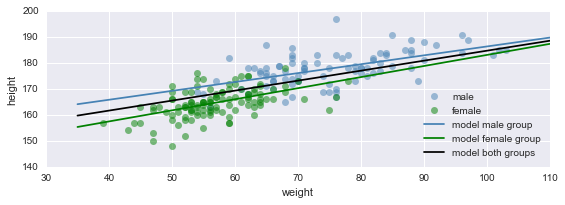

In [86]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))

mask_m = data.sex == 0
mask_f = data.sex == 1

ax.plot(data.weight[mask_m], data.height[mask_m], 'o', color="steelblue", label="male", alpha=0.5)
ax.plot(data.weight[mask_f], data.height[mask_f], 'o', color="green", label="female", alpha=0.5)

x = np.linspace(35, 110, 50)
ax.plot(x, intercept_m + x * beta_m, color="steelblue", label="model male group")
ax.plot(x, intercept_f + x * beta_f, color="green", label="model female group")
ax.plot(x, intercept + x * beta, color="black", label="model both groups")

ax.set_xlabel("weight")
ax.set_ylabel("height")
ax.legend(loc=0)
fig.tight_layout()
fig.savefig("ch16-multilevel-linear-model-fit.pdf")
fig.savefig("ch16-multilevel-linear-model-fit.png")

In [87]:
trace.get_values('error').mean()

5.1323213652455602

# Version

In [88]:
%reload_ext version_information

In [89]:
%version_information numpy, pandas, matplotlib, statsmodels, pymc3

Software,Version
Python,2.7.12 64bit [GCC 4.2.1 (Based on Apple Inc. build 5658) (LLVM build 2336.11.00)]
IPython,5.1.0
OS,Darwin 15.5.0 x86_64 i386 64bit
numpy,1.11.1
pandas,0.18.1
matplotlib,1.5.2
statsmodels,0.6.1
pymc3,3.0
